In [1]:
from simpledbf import Dbf5

import pandas as pd

import geopandas as gpd

from shapely.geometry import Point, Polygon

import requests

%matplotlib inline 

PyTables is not installed. No support for HDF output.


# Load DOB Inspections dataset

In [2]:
dbf = Dbf5('data/merge_footprints/merge_footprints.dbf')

all_inspections = dbf.to_dataframe()

In [3]:
print(len(all_inspections))
print(list(all_inspections))
all_inspections.head()[['dt_lstm','bin', 'Elevtrs']]

120593
['bin', 'dt_lstm', 'tm_lstm', 'shap_ln', 'shape_r', 'feat_cd', 'name', 'grondlv', 'doitt_d', 'cnstrc_', 'heghtrf', 'lststty', 'BiB', 'BIS_P_A', 'BIS_P_N', 'BIS_tt_', 'Boilers', 'Bldng_M', 'CnstrcD', 'CnstrcE', 'Cranes', 'DOBNOW_', 'ECB', 'ElctrcD', 'ElctrcE', 'Elevtrs', 'ERT', 'Facades', 'Illgl_C', 'Mtrl_Fl', 'Mch_C_E', 'PlmbngD', 'PlmbngE', 'QOL', 'Sstnblt', 'SWO', 'Tnnt_Hr', 'ttl_ccd', 'ttl_cmp', 'ttl_nsp', 'ttl_vlt', 'Vacate', 'Wrkr_Fl', 'WWOP', 'Latitud', 'Longitd', 'Borough', 'Address', 'BIS_Prf', 'Ttl_Prm', 'Total', 'cyclomd']


,dt_lstm,bin,Elevtrs
0,2017/08/22,4299860.0,0.0
1,2017/08/22,4300452.0,0.0
2,2017/08/22,4305475.0,0.0
3,2017/08/22,4306537.0,0.0
4,2017/12/19,3413894.0,2.0


In [4]:
all_inspections['Elevtrs'].mean()

0.1669416964500427

In [5]:
#  Confirm these are the elevator inspections: https://www1.nyc.gov/assets/buildings/html/dob-building-profiles.html#
elevator_inspections = all_inspections[all_inspections['Elevtrs'] != 0.0]
print("{} elevators inspections in the last 12 months".format(elevator_inspections['Elevtrs'].sum()))
print("{} buildings had elevator inspections in the last 12 months".format(len(elevator_inspections)))

20132.0 elevators inspections in the last 12 months
8184 buildings had elevator inspections in the last 12 months


### Mini question: what is the date range on the DOB Inspection dataset?

2009/02/14
2018/08/31


/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


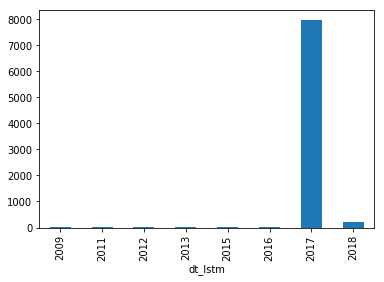

In [6]:
print(elevator_inspections['dt_lstm'].min())
print(elevator_inspections['dt_lstm'].max())

elevator_inspections['dt_lstm'] = elevator_inspections['dt_lstm'].astype("datetime64")
elevator_inspections.groupby(elevator_inspections["dt_lstm"].dt.year).count()['bin'].plot(kind="bar")

### Mini question: what is the date range on the DOB Elevators Violations dataset?

In [7]:
all_violations = pd.read_csv('data/DOB_Violations.csv')
print(f"Length with Nans: {len(all_violations)}")

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Length with Nans: 2035211


In [8]:
list(all_violations)

['ISN_DOB_BIS_VIOL',
 'BORO',
 'BIN',
 'BLOCK',
 'LOT',
 'ISSUE_DATE',
 'VIOLATION_TYPE_CODE',
 'VIOLATION_NUMBER',
 'HOUSE_NUMBER',
 'STREET',
 'DISPOSITION_DATE',
 'DISPOSITION_COMMENTS',
 'DEVICE_NUMBER',
 'DESCRIPTION',
 'ECB_NUMBER',
 'NUMBER',
 'VIOLATION_CATEGORY',
 'VIOLATION_TYPE']

In [9]:
all_violations['ISSUE_DATE'] = pd.to_datetime(all_violations['ISSUE_DATE'], errors='coerce')
all_violations = all_violations.dropna(subset=['ISSUE_DATE'])

In [10]:
print(len(all_violations))

2035155


## Plot frequency of types of violations

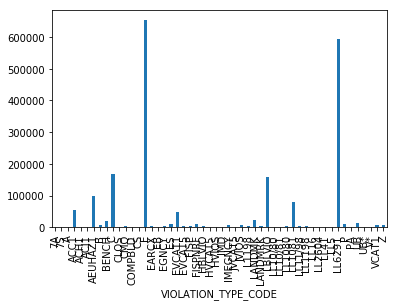

In [11]:
all_violations.groupby('VIOLATION_TYPE_CODE').count()['BIN'].plot('bar')

## Look at violations after 2000
Doing this because a lot of violations are being grouped into 1970 and 1901 for some reason

In [12]:
cut_off_date = '2000-01-01'
all_violations = all_violations[all_violations['ISSUE_DATE'] > cut_off_date]
print("Length of all_violations after date cutoff {}".format(len(all_violations)))

Length of all_violations after date cutoff 599112


# Look at just Boiler dates

In [13]:
boiler_violations = all_violations[all_violations['VIOLATION_TYPE_CODE']  == 'B']
print(len(boiler_violations))

176


Min: 2000-02-07 00:00:00
Max: 2018-10-09 00:00:00


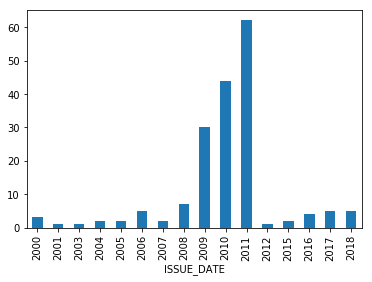

In [14]:
print("Min: {}".format(boiler_violations['ISSUE_DATE'].min()))
print("Max: {}".format(boiler_violations['ISSUE_DATE'].max()))

boiler_violations.groupby(boiler_violations['ISSUE_DATE'].dt.year).count()['BIN'].plot(kind="bar")

# Look at just Elevator dates

In [15]:
elevator_violations = all_violations[all_violations['VIOLATION_TYPE_CODE']  == 'E']
print(len(elevator_violations))

227005


Min: 2000-01-03 00:00:00
Max: 2019-04-17 00:00:00


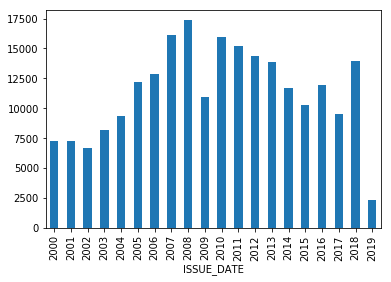

In [16]:
print("Min: {}".format(elevator_violations['ISSUE_DATE'].min()))
print("Max: {}".format(elevator_violations['ISSUE_DATE'].max()))

elevator_violations.groupby(elevator_violations['ISSUE_DATE'].dt.year).count()['BIN'].plot(kind="bar")

# Look at Boiler Inspections from: 
https://data.cityofnewyork.us/Housing-Development/DOB-NOW-Safety-Boiler/52dp-yji6

In [17]:
boiler_now_inspections = pd.read_csv("data/DOB_NOW_Boiler_Safety.csv")

In [18]:
list(boiler_now_inspections)

['Tracking Number',
 'Boiler ID',
 'Report Type',
 'ApplicantFirst Name',
 'Applicant Last Name',
 'Applicant License Type',
 'Applicant License Number',
 'Owner First Name',
 'Owner Last Name',
 'Boiler Make',
 'Boiler Model',
 'Pressure Type',
 'Inspection Type',
 'Inspection Date',
 'Defects Exist',
 'LFF (45 Days)',
 'LFF (180 Days)',
 'Filing Fee',
 'Total Amount Paid',
 'Report Status',
 'Bin Number']

# Look at these suckers over time

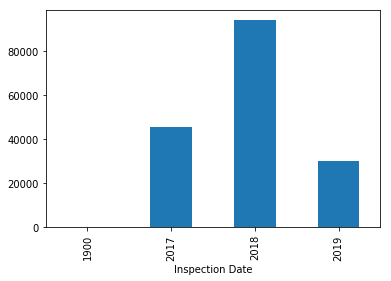

In [19]:
boiler_now_inspections['Inspection Date'] = pd.to_datetime(boiler_now_inspections['Inspection Date'])
boiler_now_inspections.groupby(boiler_now_inspections['Inspection Date'].dt.year).count()['Bin Number'].plot('bar')

In [20]:
defected_boilers = boiler_now_inspections[boiler_now_inspections['Defects Exist'] == 'Yes']

print(len(defected_boilers))
print(len(boiler_now_inspections))
len(defected_boilers) / len(boiler_now_inspections) * 100

13764
169583


8.116379589935312

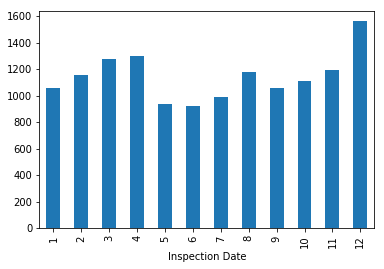

In [21]:
defected_boilers.groupby(defected_boilers['Inspection Date'].dt.month).count()['Bin Number'].plot('bar')

So it seems like month could be a good feature

# What types of boilers have defects?

In [22]:
boiler_inspections_by_make = boiler_now_inspections.groupby(boiler_now_inspections['Boiler Make']).count()['Bin Number']
boiler_inspections_by_make = pd.DataFrame(boiler_inspections_by_make)
boiler_inspections_by_make.head()

,Bin Number
Boiler Make,
.............,2
175000,1
19 HE-5,2
2 FEDERAL,1
2006,2


In [23]:
boiler_defects_by_make = defected_boilers.groupby(defected_boilers['Boiler Make']).count()['Bin Number']

In [24]:
boiler_defects_by_make = pd.DataFrame(boiler_defects_by_make)
boiler_defects_by_make.head().index

Index(['A O SMITH', 'A OSMITH', 'A.L. EASTMOND', 'A.L.EASTMOND', 'A.O. SMITH'], dtype='object', name='Boiler Make')

In [44]:
def create_boiler_make_ratios(row):
#     print(row.name)
#     print(type(row))
    total_of_make = boiler_inspections_by_make[boiler_inspections_by_make.index == row.name]['Bin Number']
#     print(total_of_make)
#     print(type(total_of_make))
#     print(row['Bin Number'] / total_of_make.values)
#     print()
#     print(row['Bin Number'])
#     print(type(row['Bin Number']))
#     print("-------")
    
    return float(row['Bin Number'] / total_of_make.values) #total of that make

In [48]:
boiler_defects_by_make['Make Defect Ratio'] = boiler_defects_by_make.apply(lambda row: create_boiler_make_ratios(row), axis=1)

In [65]:
boiler_defects_by_make.sort_values(by=['Make Defect Ratio'], ascending=False).head(100)

,Bin Number,Make Defect Ratio
Boiler Make,,
SLANT/FIN CG-375 HEC,1,1.000000
NAT'L. RAD,1,1.000000
NEW HB SMITH,1,1.000000
FEDERAL FST-300,1,1.000000
NATCO BOIL,1,1.000000
FERRAR & TREF,2,1.000000
UNITED 255,2,1.000000
BESTBOILER,1,1.000000
FERRAR & TREFTS,3,1.000000


# Where are these defects happening?

# Find intersection of elevator inspections and violations
We want to do this so we can sus out elevator inspections that did not result in a violation (our negative labels)

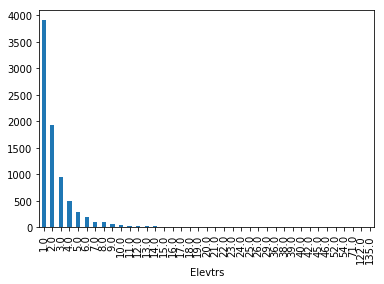

In [28]:
elevator_inspections.groupby('Elevtrs').count()['bin'].plot('bar')

In [29]:
elevator_inspections = elevator_inspections.set_index('bin')

In [30]:
elevator_violations = elevator_violations.set_index('BIN')

### 